In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import random
import calendar
from collections import defaultdict




from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import sys
sys.path.append('/data/gbmc/Rodeo_Submission/Competition_Functions')
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly
from Processing_Functions import process_forecast_date, process_seasonal_forecasts


sys.path.append('/data/gbmc/Rodeo_Submission/Post_Rodeo_Work/ML_Functions.py')
from ML_Functions import Specific_Heads, Model_Block, SumPinballLoss, EarlyStopper
# sys.path.append('/data/gbmc/Functions')
# from Efficiency_Functions import kling_gupta_efficiency, nash_sutcliffe_efficiency, KGE_Loss, NSE_Loss, Combined_Loss


sys.path.append('/data/gbmc/Rodeo_Submission/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column
import zipfile

ModuleNotFoundError: No module named 'Data_Transforming'

# Data Preparation

In [3]:
# from Folder_Work import extract_from_individual_zip, extract_from_main_zip, remove_redundant_folders
# USGS = '/data/gbmc/Rodeo_Submission/Rodeo_Data/streamflows.zip'
# USGS_Path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/'
# extract_from_individual_zip(USGS, USGS_Path)

# extract_from_individual_zip('/data/gbmc/Rodeo_Submission/Rodeo_Data/digital_elevation_models.zip')

## Lists of  basins and their quantiles

In [4]:
monthly_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',
    'fontenelle_reservoir_inflow', 'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow',
    'missouri_r_at_toston','owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',
    'ruedi_reservoir_inflow', 'skagit_ross_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin', 'sweetwater_r_nr_alcova',
    'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]


USGS_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',   
    'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow', 'merced_river_yosemite_at_pohono_bridge', 'missouri_r_at_toston',
    'owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',    'san_joaquin_river_millerton_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin',
    'sweetwater_r_nr_alcova', 'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]

basins = list(set(monthly_basins + USGS_basins))




In [5]:
## Historic Quantiles

quantiles = {
    'american_river_folsom_lake': {'10': 8.25890931, '50': 16.15167713, '90': 82.37816025},
    'animas_r_at_durango': {'10': 148.99123825, '50': 279.32773825, '90': 373.75623825},
    'boise_r_nr_boise': {'10': 775.93723825, '50': 1033.72273825, '90': 1478.30723825},
    'boysen_reservoir_inflow': {'10': 204.87023825, '50': 438.94273825, '90': 841.13573825},
    'colville_r_at_kettle_falls': {'10': 57.98373825, '50': 116.11323825, '90': 187.70223825},
    'detroit_lake_inflow': {'10': 6.86947102, '50': 13.29894623, '90': 30.09213939},
    'dillon_reservoir_inflow': {'10': 54.85473825, '50': 117.36573825, '90': 142.10273825},
    'fontenelle_reservoir_inflow': {'10': 286.99973825, '50': 420.65873825, '90': 828.92423825},
    'green_r_bl_howard_a_hanson_dam': {'10': 153.56873825, '50': 233.51123825, '90': 325.42373825},
    'hungry_horse_reservoir_inflow': {'10': 1437.45473825, '50': 1808.90123825, '90': 2254.66223825},
    'libby_reservoir_inflow': {'10': 3174.74673825, '50': 4428.96523825, '90': 5197.77823825},
    'missouri_r_at_toston': {'10': 851.17273825, '50': 1533.77423825, '90': 1883.71223825},
    'owyhee_r_bl_owyhee_dam': {'10': 103.47323825, '50': 160.73323825, '90': 499.06673825},
    'pecos_r_nr_pecos': {'10': 5.90123825, '50': 32.88623825, '90': 46.72873825},
    'pueblo_reservoir_inflow': {'10': 123.28373825, '50': 201.71073825, '90': 297.95423825},
    'ruedi_reservoir_inflow': {'10': 58.50173825, '50': 96.82073825, '90': 130.72273825},
    'skagit_ross_reservoir': {'10': 928.05423825, '50': 1117.87923825, '90': 1351.08423825},
    'snake_r_nr_heise': {'10': 1936.54673825, '50': 2373.29973825, '90': 3291.39823825},
    'stehekin_r_at_stehekin': {'10': 492.02873825, '50': 557.46223825, '90': 658.41673825},
    'sweetwater_r_nr_alcova': {'10': 14.10623825, '50': 30.35373825, '90': 74.62323825},
    'taylor_park_reservoir_inflow': {'10': 39.50873825, '50': 60.36173825, '90': 85.32823825},
    'virgin_r_at_virtin': {'10': 14.43423825, '50': 29.26573825, '90': 57.64473825},
    'weber_r_nr_oakley': {'10': 57.79523825, '50': 83.71873825, '90': 115.95923825},
    'yampa_r_nr_maybell': {'10': 420.85673825, '50': 802.86223825, '90': 1050.70273825},
    'san_joaquin_river_millerton_reservoir': {'10': 8.25890931, '50': 16.15167713, '90': 82.37816025},
    'merced_river_yosemite_at_pohono_bridge': {'10': 6.1894047, '50': 16.65905307, '90': 33.48977683},

}


## Downloading CSV Files

In [6]:
# Extract Data
selected_years = range(2000,2024,2)

era5_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/era5'
era5 = csv_dictionary(era5_folder, basins, years=selected_years)
era5 = add_day_of_year_column(era5)

flow_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_monthly_naturalized_flow'
flow = csv_dictionary(flow_folder, monthly_basins)
flow = filter_rows_by_year(flow, 1998)

climatology_file_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/climate_indices.csv'
climate_indices = pd.read_csv(climatology_file_path)
climate_indices['date'] = pd.to_datetime(climate_indices['date'])
climate_indices.set_index('date', inplace = True)
climate_indices.drop('Unnamed: 0', axis = 1, inplace = True)
climate_indices = climate_indices[~climate_indices.index.duplicated(keep='first')]

root_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/seasonal_forecasts'
seasonal_forecasts = read_nested_csvs(root_folder)

USGS_flow_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows'
USGS_flow = csv_dictionary(USGS_flow_folder, USGS_basins)

Static_variables = pd.read_csv('/data/gbmc/Rodeo_Submission/Rodeo_Data/static_indices.csv', index_col= 'site_id')


## Transforming Flow Values

In [7]:
# Convert monthly flow values to daily flow estimates
daily_flow = {}

# Iterate through the dictionary and apply generate_daily_flow to each DataFrame
for key, df in flow.items():
    daily_flow[key] = generate_daily_flow(df, persistence_factor=0.7)

# Replacing monhtly data for normalised USGS when available
daily_flow = use_USGS_flow_data(daily_flow, USGS_flow)

In [8]:
# Introducing the data from San_jaoqin and Merced, normalised by the yearly flow given
path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/san_joaquin_river_millerton_reservoir.csv'
name = 'san_joaquin_river_millerton_reservoir'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/san_joaquin_river_millerton_reservoir.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/merced_river_yosemite_at_pohono_bridge.csv'
name = 'merced_river_yosemite_at_pohono_bridge'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/merced_river_yosemite_at_pohono_bridge.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/detroit_lake_inflow.csv'
name = 'detroit_lake_inflow'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/detroit_lake_inflow.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

In [9]:
# detroit and sweetwater train monthly are fucked
for key, df in daily_flow.items():
    length = len(df)
    nan_count = df['daily_flow'].isna().sum()
    
    # Check if the DataFrame is not empty
    if not df.empty:
        latest_date = df.index.max()
        print(f"{key}: Length = {length}, NaN count in 'daily_flow' = {nan_count}, Latest Date = {latest_date}")
    else:
        print(f"{key}: DataFrame is empty, Length = {length}, NaN count in 'daily_flow' = {nan_count}")

    

animas_r_at_durango: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
boise_r_nr_boise: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
boysen_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
colville_r_at_kettle_falls: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
detroit_lake_inflow: Length = 3828, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
dillon_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
fontenelle_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
green_r_bl_howard_a_hanson_dam: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
hungry_horse_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
libby_reservoir_inflow: Length = 4282, NaN count i

## Scaling Variable Values

In [10]:
climate_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/climate_normalization_scaler.save'
climate_scaler = joblib.load(climate_scaler_filename) 
climate_indices = pd.DataFrame(climate_scaler.transform(climate_indices), columns=climate_indices.columns, index=climate_indices.index)

era5_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/era5_scaler.save'
era5_scaler = joblib.load(era5_scaler_filename) 
era5 = {key: pd.DataFrame(era5_scaler.transform(df), columns=df.columns, index=df.index) for key, df in era5.items()}

for basin, df in daily_flow.items(): 
    flow_scaler_filename = f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
    flow_scaler = joblib.load(flow_scaler_filename) 
    daily_flow[basin] = pd.DataFrame(flow_scaler.transform(df), columns=df.columns, index=df.index)

seasonal_scaler_filename = "/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/seasonal_scaler.save"
seasonl_scaler = joblib.load(seasonal_scaler_filename)
seasonal_forecasts = {key: pd.DataFrame(seasonl_scaler.transform(df), columns=df.columns, index=df.index ) for key, df in seasonal_forecasts.items()}

static_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/static_scaler.save'
static_scaler = joblib.load(static_scaler_filename) 
Static_variables = pd.DataFrame(static_scaler.transform(Static_variables), columns=Static_variables.columns, index=Static_variables.index)



In [11]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# import joblib


# for basin, dataframe in daily_flow.items(): 
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(dataframe)
#     scaled_dataframe = pd.DataFrame(scaled_data, columns=dataframe.columns)
#     joblib.dump(scaler, f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save')


In [12]:
# Create scaled climatology for each day

climatological_flows = {}

for basin, df in daily_flow.items():
    # Extract day of year and flow values
    df['day_of_year'] = df.index.dayofyear

    grouped = df.groupby('day_of_year')['daily_flow'].quantile([0.1, 0.5, 0.9]).unstack(level=1)

    climatological_flows[basin] = pd.DataFrame({
        'day_of_year': grouped.index,
        '10th_percentile_flow': grouped[0.1],
        '50th_percentile_flow': grouped[0.5],
        '90th_percentile_flow': grouped[0.9]
    })
    
    climatological_flows[basin].set_index('day_of_year', inplace=True)

    # Drop the temporary 'day_of_year' column from the original dataframe
    df.drop(columns='day_of_year', inplace=True)

In [13]:
folder_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/climatological_flows'


for basin, df in climatological_flows.items():
    csv_name = f'{basin}_climatological_flows.csv'
    csv_path = os.path.join(folder_path, csv_name)
    df.to_csv(csv_path, index=False)

In [14]:
scaled_quantiles = {}

# Iterate through the dictionary and scale each value
for key, inner_dict in quantiles.items():
    values = list(inner_dict.values())    
    values = [[value] for value in values]
    scaled_values = flow_scaler.fit_transform(values)
    scaled_values = [value[0] for value in scaled_values]
    scaled_inner_dict = dict(zip(inner_dict.keys(), scaled_values))
    scaled_quantiles[key] = scaled_inner_dict



In [15]:
# for basin, dataframe in daily_flow.items(): 
#     print(np.mean(dataframe))

# Model Running

In [16]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim.lr_scheduler as lr_scheduler


import sys
sys.path.append('/data/gbmc/Rodeo_Submission/Performance_Evaluation') 
from Evaluation_Functions import test_performance_for_basin_and_season



In [17]:
# Weight between body and head is unclear, how they should be balanced

LR = 1e-4
static_size = np.shape(Static_variables)[1]
forecast_size = np.shape(seasonal_forecasts['american_river_folsom_lake_2000_apr'])[1]
History_Fourier_in_forcings = 0 #2*3*(6 - 1)
Climate_guess = 3
History_Statistics_in_forcings = 5*2
body_input_size = forecast_size + static_size + History_Fourier_in_forcings + History_Statistics_in_forcings  + Climate_guess + 3
body_output_size, body_hidden_size, body_num_layers =  16, 64, 2
body_dropout, body_bidirectional, learning_rate_body = 0.5, True, LR
head_input_size, head_output_size, head_hidden_size, head_num_layers =  body_output_size , 3, 64, 1
head_dropout, head_bidirectional, learning_rate_head, learning_rate_general_head = 0.1, True, LR, LR

days  = 90
hidden_variables_size = 17

# Randomness
seed = 42 ; torch.manual_seed(seed) ; random.seed(seed) ; np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hydra_Body, model_heads, General_Hydra_Head, optimizer, scheduler = initialize_models_optimizers(basins, body_input_size, body_hidden_size, body_num_layers, body_output_size, body_dropout, body_bidirectional,
#                     head_input_size, head_hidden_size, head_num_layers, head_output_size, head_dropout, head_bidirectional,
#                     days, hidden_variables_size, learning_rate_body, learning_rate_head, learning_rate_general_head, LR, device)


# Making Models

In [18]:
# General Body
hindcast_input_size = 10
body_forecast_input_size = body_input_size
body_hidden_size = 32
body_num_layers = 1
body_hindcast_output_size = 4
body_forecast_output_size = 6
General_Body = Model_Block(hindcast_input_size, body_forecast_input_size, body_hindcast_output_size, body_forecast_output_size, body_hidden_size, body_num_layers, device)

# General Head
head_hindcast_input_size =  body_hindcast_output_size
head_forecast_input_size = body_forecast_output_size
head_hidden_size = 32
head_num_layers = 1
head_hindcast_output_size = 4 # This one unimportant as it isn't being used anywhere
head_forecast_output_size = 3
General_Head = Model_Block(head_hindcast_input_size, head_forecast_input_size, head_hindcast_output_size, head_forecast_output_size, head_hidden_size, head_num_layers, device)


# Specific Heads
extra_hindcast = 1
extra_forecast = 1
specific_head_hindcast_input_size = head_hindcast_input_size + extra_hindcast
specific_head_forecast_input_size = head_forecast_input_size + extra_forecast
specific_head_hidden_size = 32
specific_head_num_layers = 1
specific_head_hindcast_output_size = 4 # This one unimportant as it isn't being used anywhere
specific_head_forecast_output_size = 3
Specific_Heads = Specific_Heads(basins, specific_head_hindcast_input_size, specific_head_forecast_input_size, specific_head_hindcast_output_size, specific_head_forecast_output_size, specific_head_hidden_size, specific_head_num_layers, device)

# Define Optimiser, Scheduler, and Criterion

In [19]:
params_to_optimize = list(General_Head.parameters()) + list(General_Body.parameters())

# Add parameters from specific heads
for basin, model in Specific_Heads.items():
    params_to_optimize += list(model.parameters())

optimizer = torch.optim.Adam(params_to_optimize, lr=LR, weight_decay = 1e-1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1e4)

criterion = SumPinballLoss(quantiles = [0.1, 0.5, 0.9])



In [20]:
# First build list of all possible forecast dates, can use any random basin to initialise this
basin = 'animas_r_at_durango' 
All_Dates = daily_flow[basin].index[
    ((daily_flow[basin].index.month < 6) | ((daily_flow[basin].index.month == 6) & (daily_flow[basin].index.day < 25))) &
    ((daily_flow[basin].index.year % 2 == 0) | ((daily_flow[basin].index.month > 10) | ((daily_flow[basin].index.month == 10) & (daily_flow[basin].index.day >= 1))))
]
All_Dates = All_Dates[All_Dates.year > 1998]


# Validation Year
Val_Dates = All_Dates[All_Dates.year == 2022]
All_Dates = All_Dates[All_Dates.year < 2022]


basin_to_remove = 'sweetwater_r_nr_alcova'

if basin_to_remove in basins:
    basins.remove(basin_to_remove)

In [21]:
n_epochs, batch_size = 30, 1
group_lengths = [7, 10, 20, 30, 50, 60, 70, 120, 150]
group_lengths = [10, 20, 30,110, 120, 150]
group_lengths = np.arange(180)
Train_Mode = True

In [22]:
early_stopper = None
#Basin,Climate = Model_Run(All_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, early_stopper, n_epochs , batch_size, group_lengths, Train_Mode, device, feed_forcing= False)

In [23]:
# Train Test Loop
# Work on owyhee, colville, dillon, animas
total_epochs = n_epochs
feed_forcing = False
early_stopper = EarlyStopper(patience=10, min_delta=0.01)
daily_flow['dillon_reservoir_inflow']
#'dillon_reservoir_inflow',
train_basins = ['dillon_reservoir_inflow']
general_losses, specific_losses, val_general_losses, val_specific_losses, climate_losses = [[] for _ in range(5)]
for epoch in range(total_epochs):  # Use 'range' to iterate over epochs
    # Training
    print('True Epoch is', epoch)
    train_general_loss, train_specific_loss, climate_loss = Model_Run(All_Dates, train_basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, n_epochs=1, batch_size=batch_size, group_lengths=group_lengths, Train_Mode=True, device=device, feed_forcing = feed_forcing)
    general_losses.append(train_general_loss)
    specific_losses.append(train_specific_loss)

    # Validation
    #val_general_loss, val_specific_loss, climate_loss = Model_Run(Val_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, early_stopper = None,n_epochs=1, batch_size=batch_size, group_lengths=group_lengths, Train_Mode=False, device=device, feed_forcing = feed_forcing)
    #val_general_losses.append(val_general_loss)
    #val_specific_losses.append(val_specific_loss)
    #climate_losses.append(climate_loss)

    if early_stopper.early_stop(0.5*(np.array(val_specific_loss) + np.array(val_general_loss))):
        stop


NameError: name 'EarlyStopper' is not defined

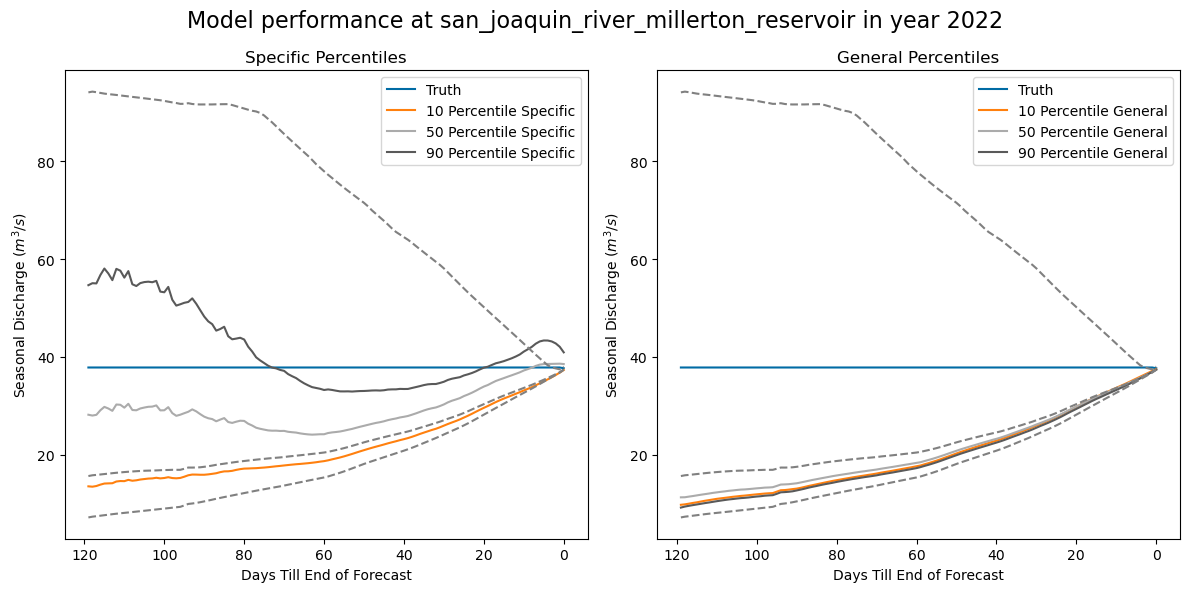

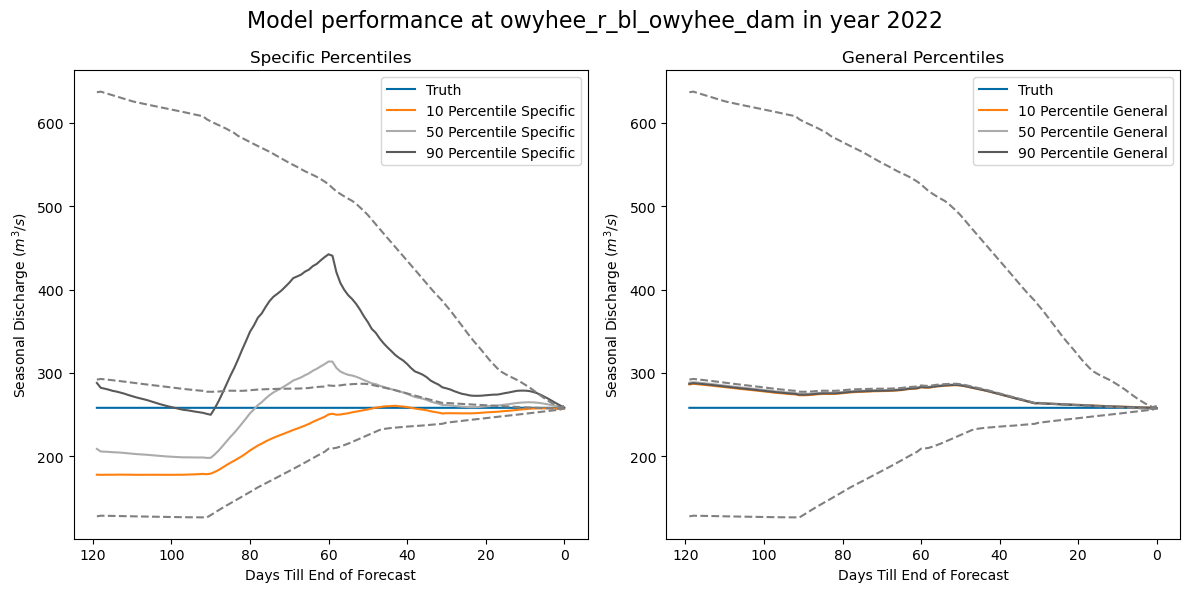

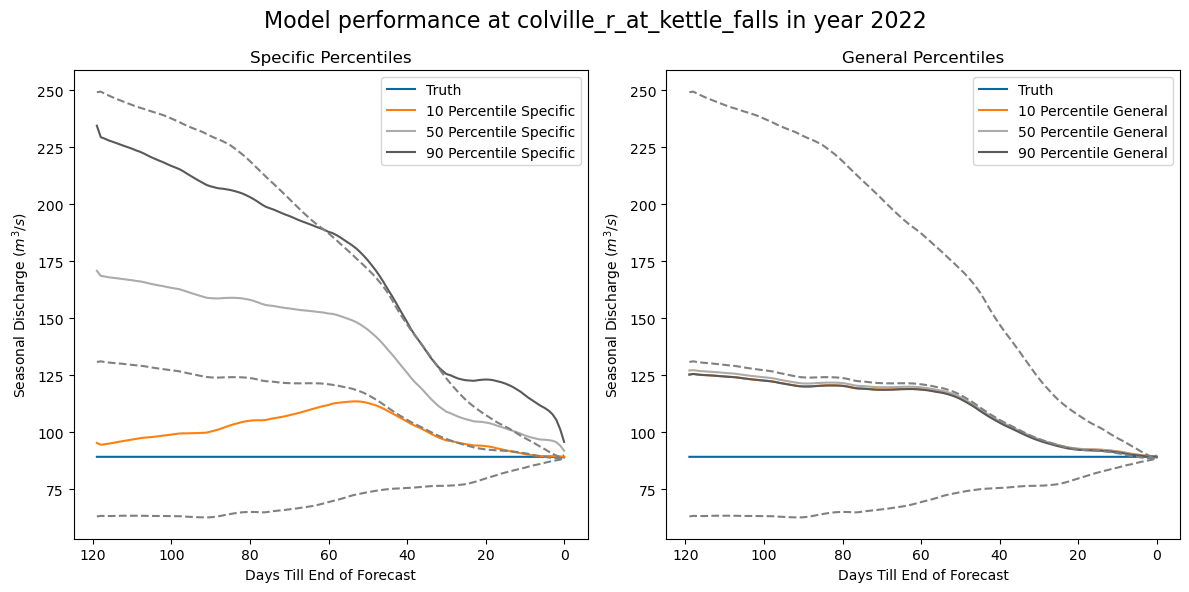

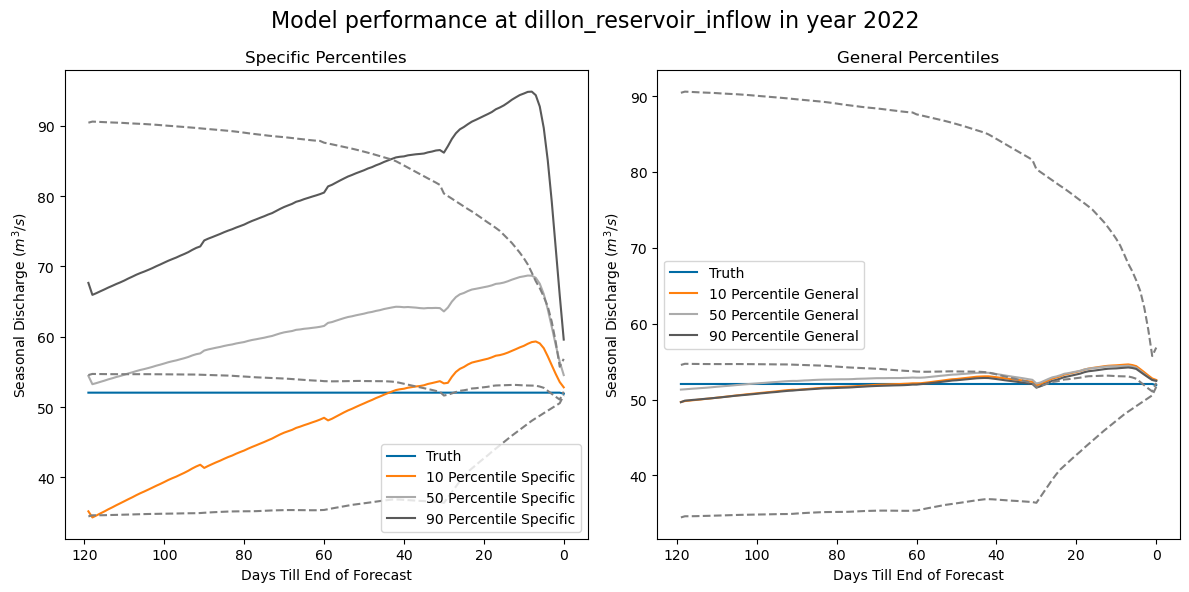

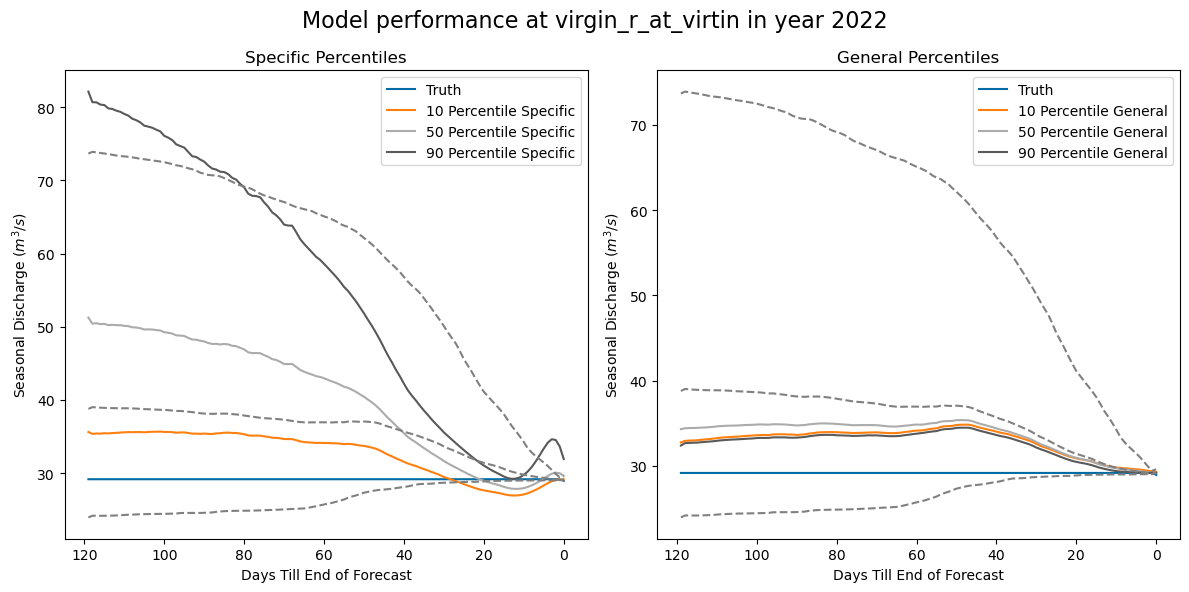

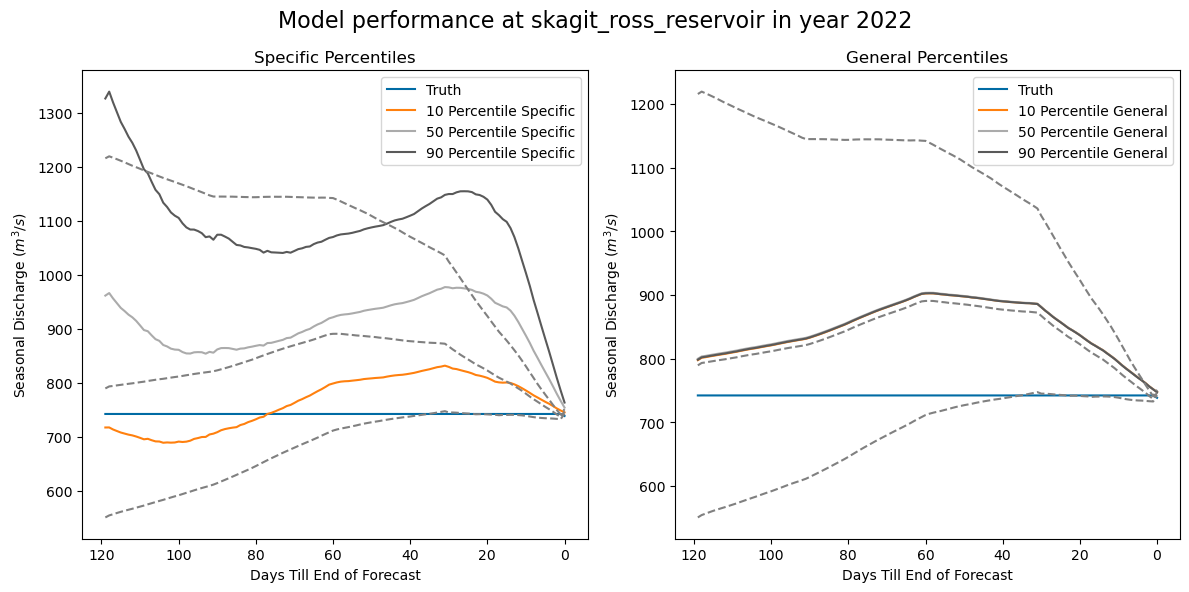

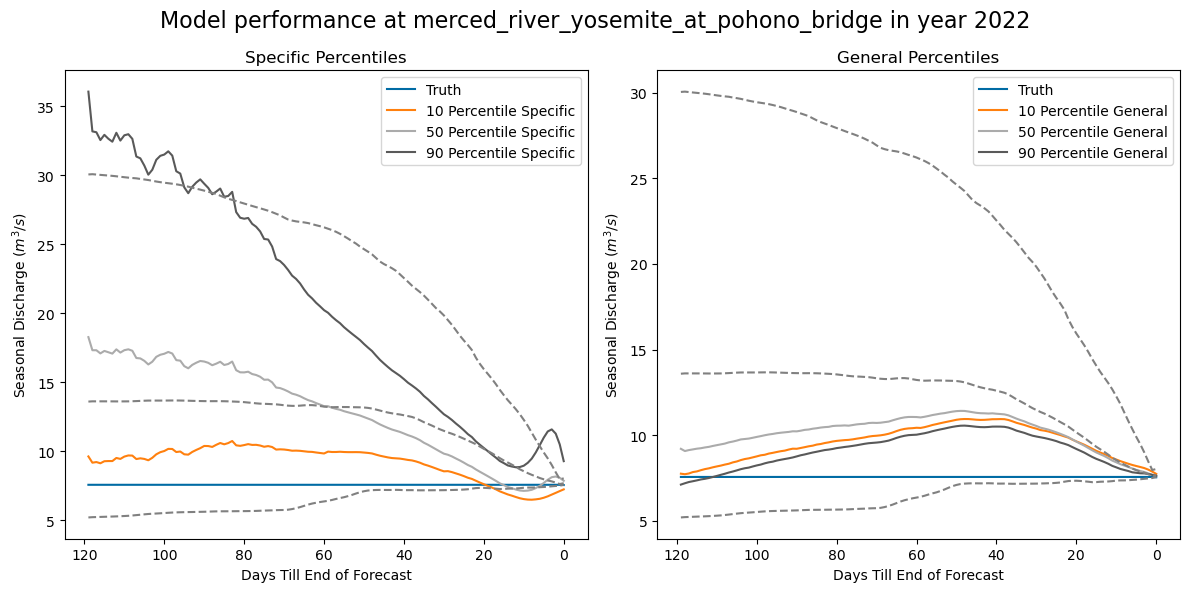

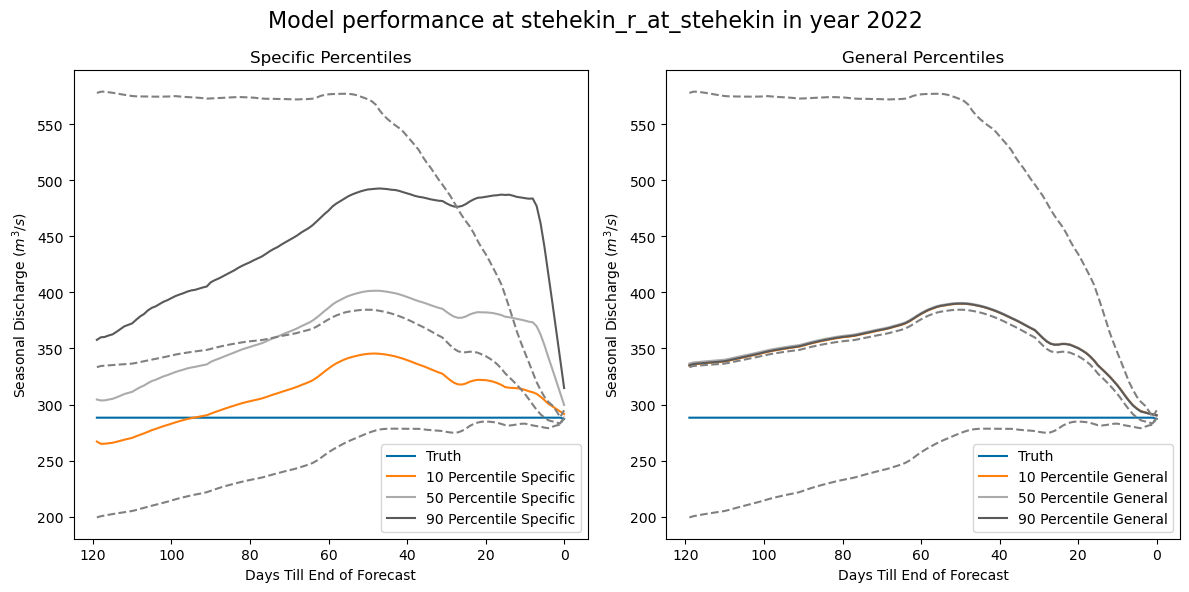

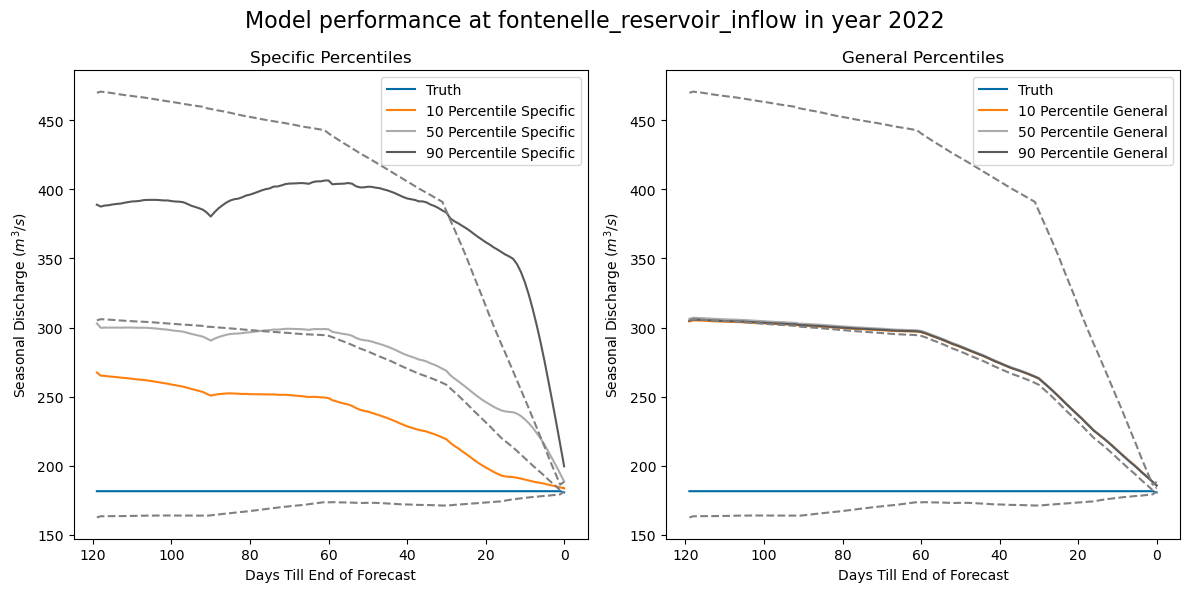

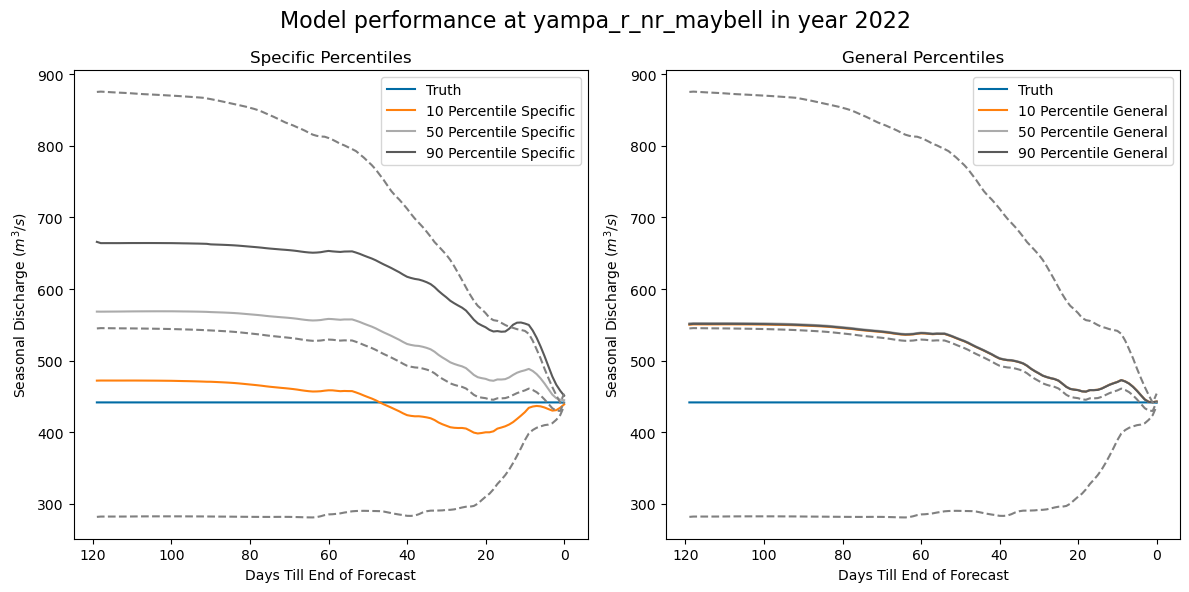

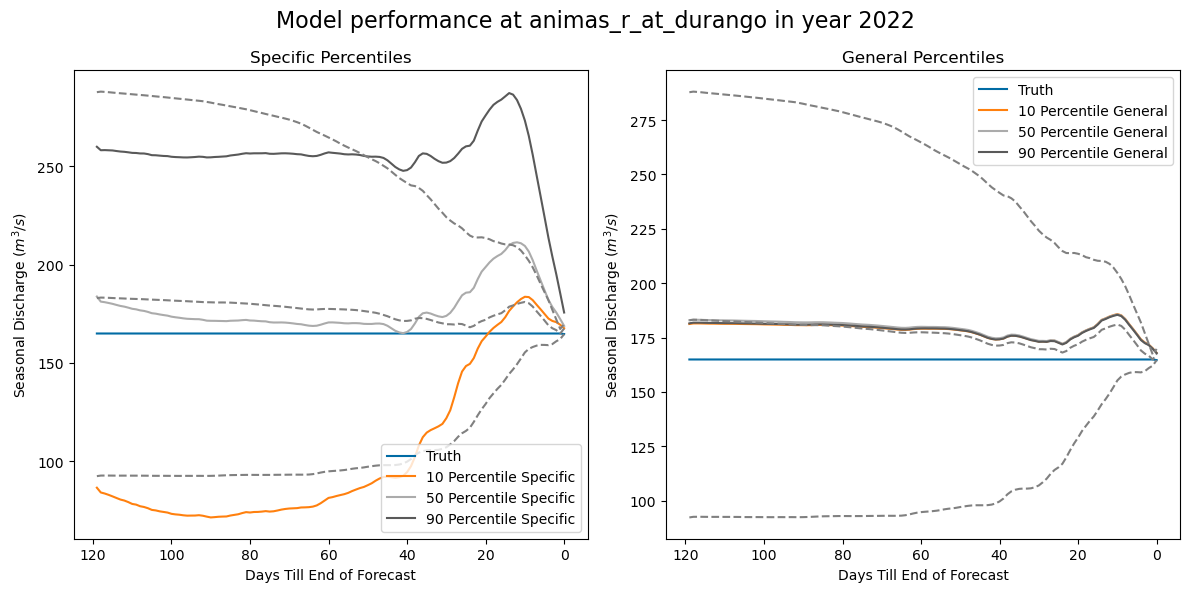

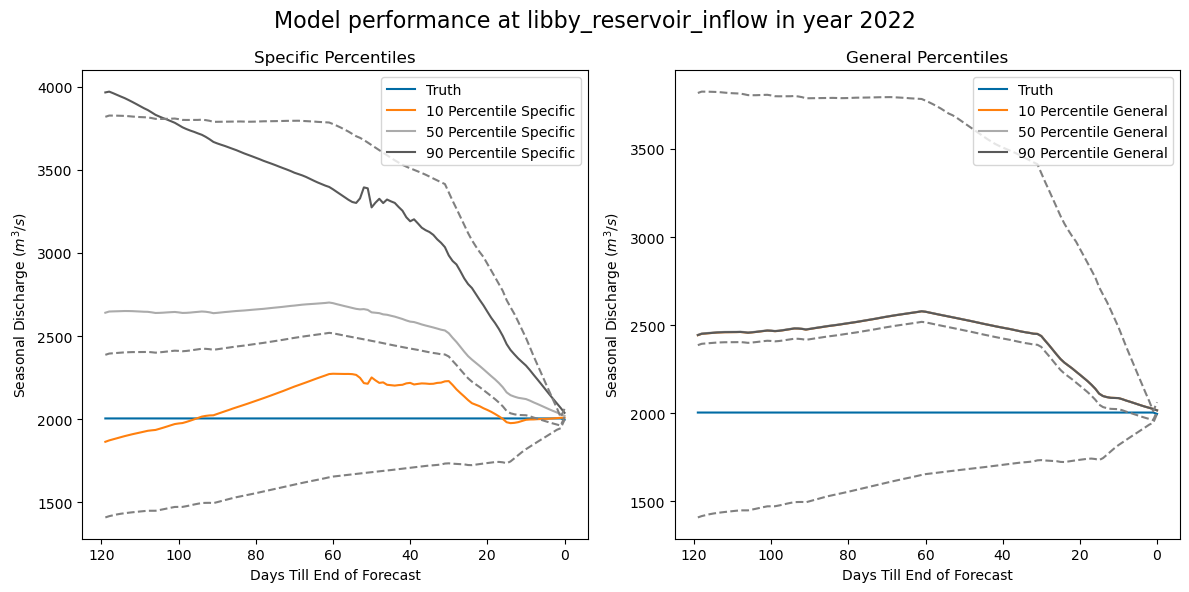

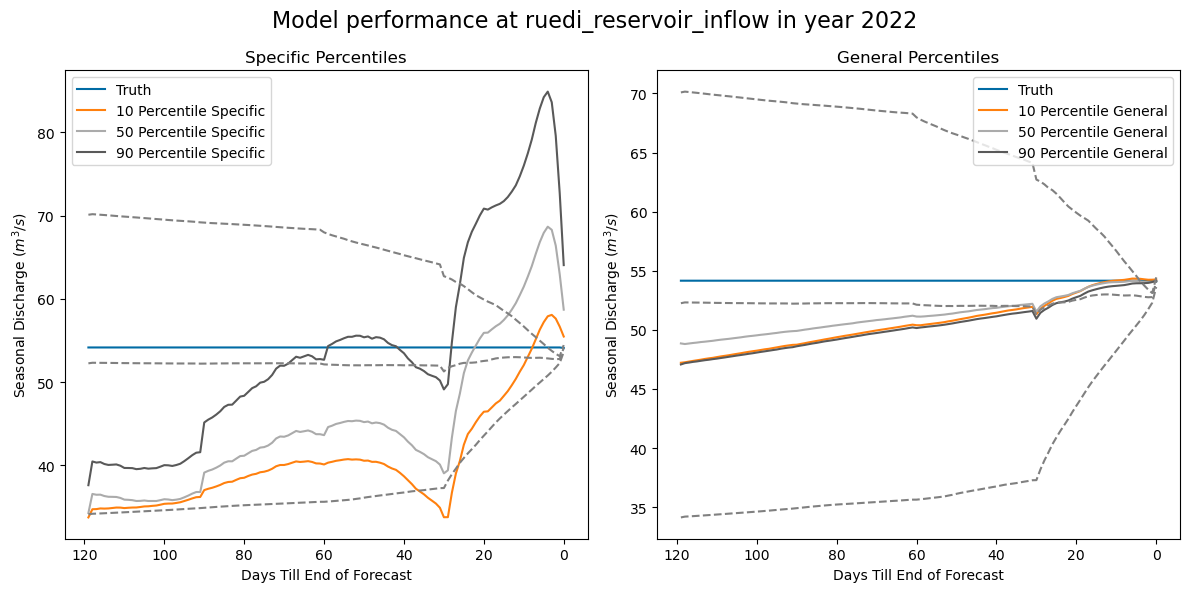

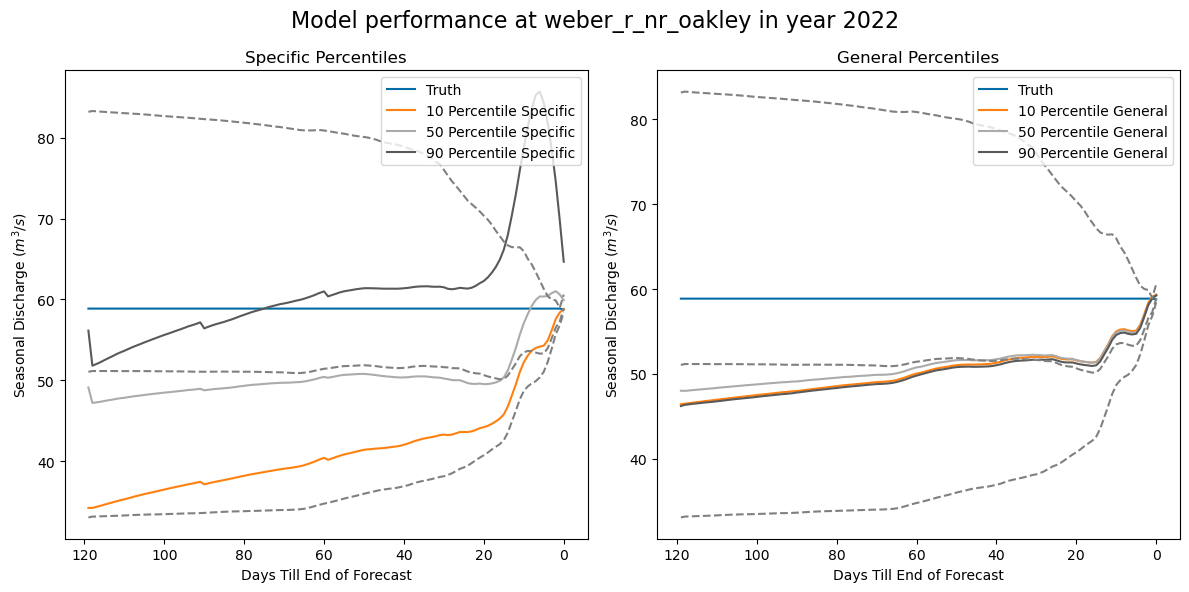

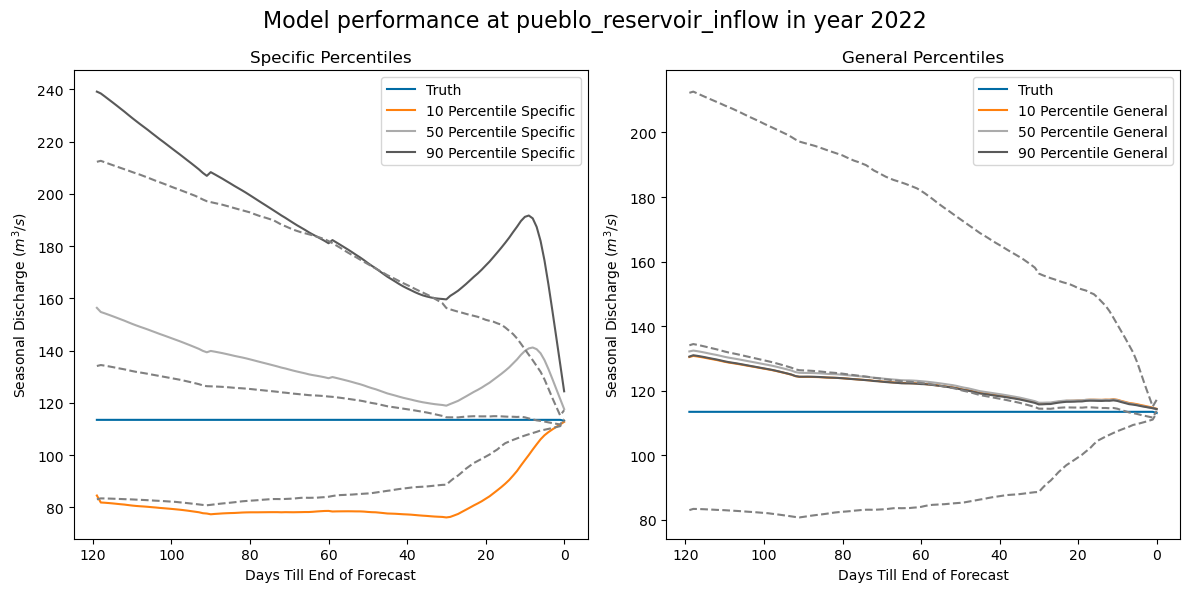

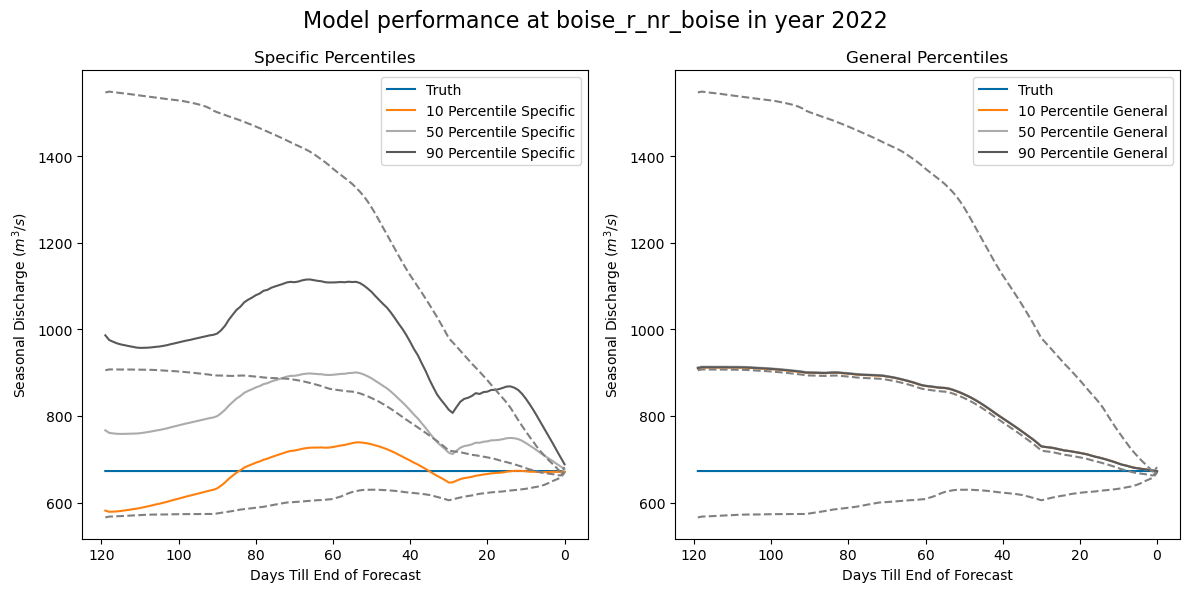

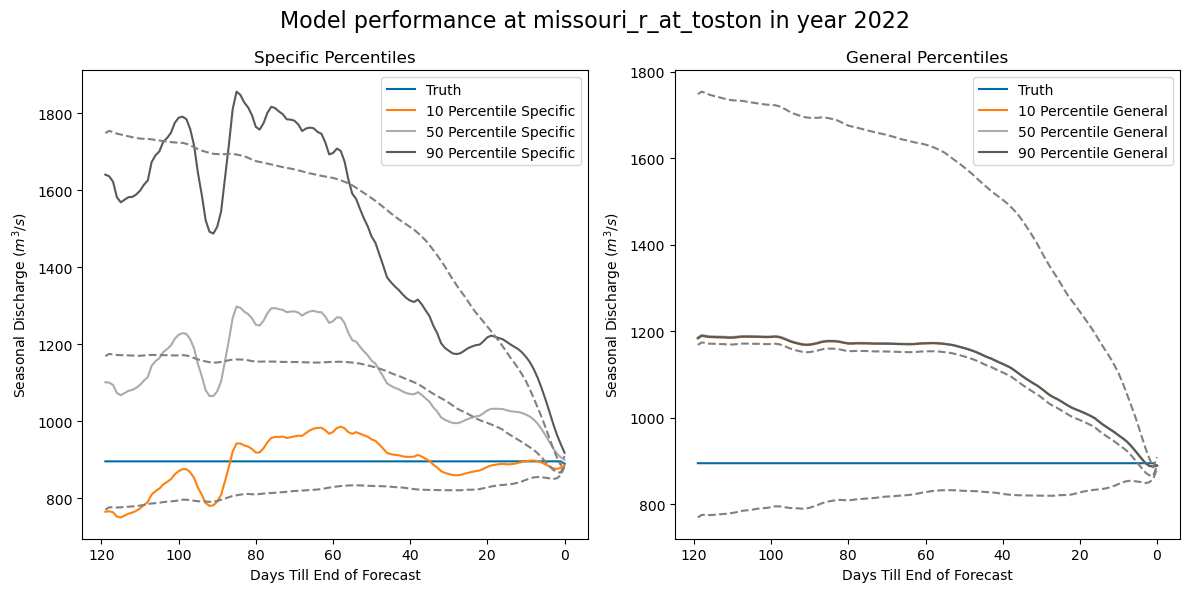

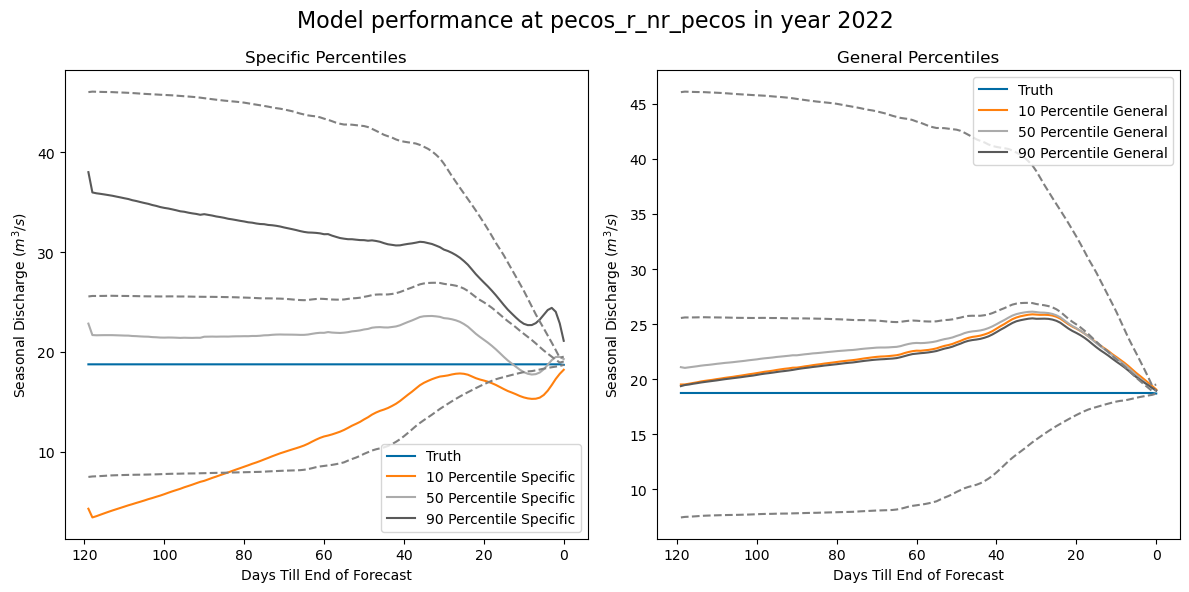

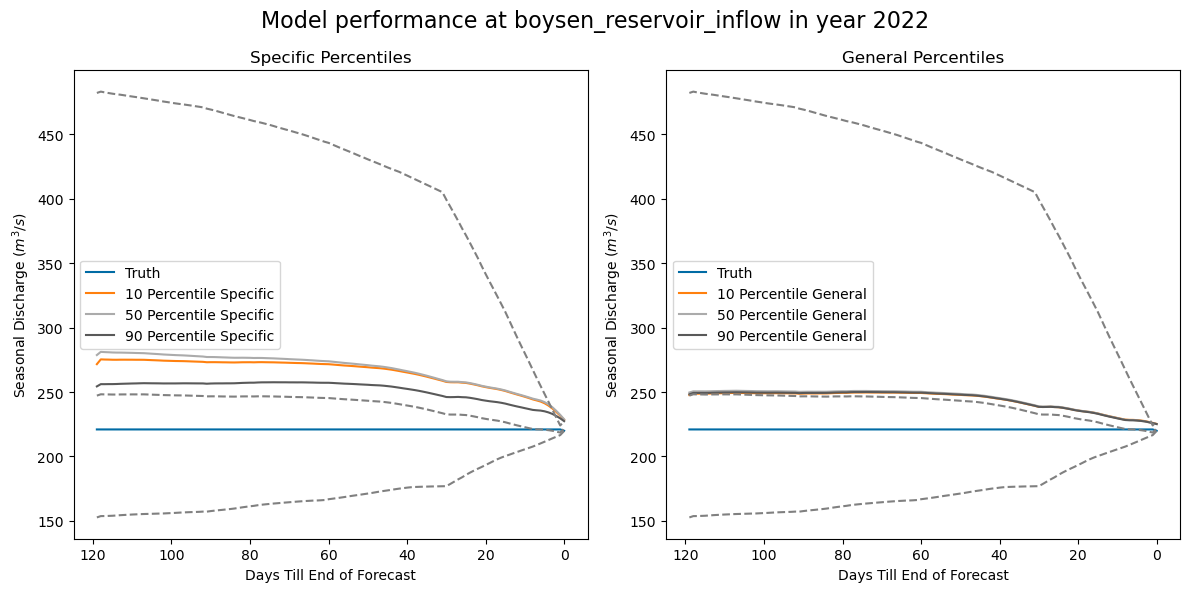

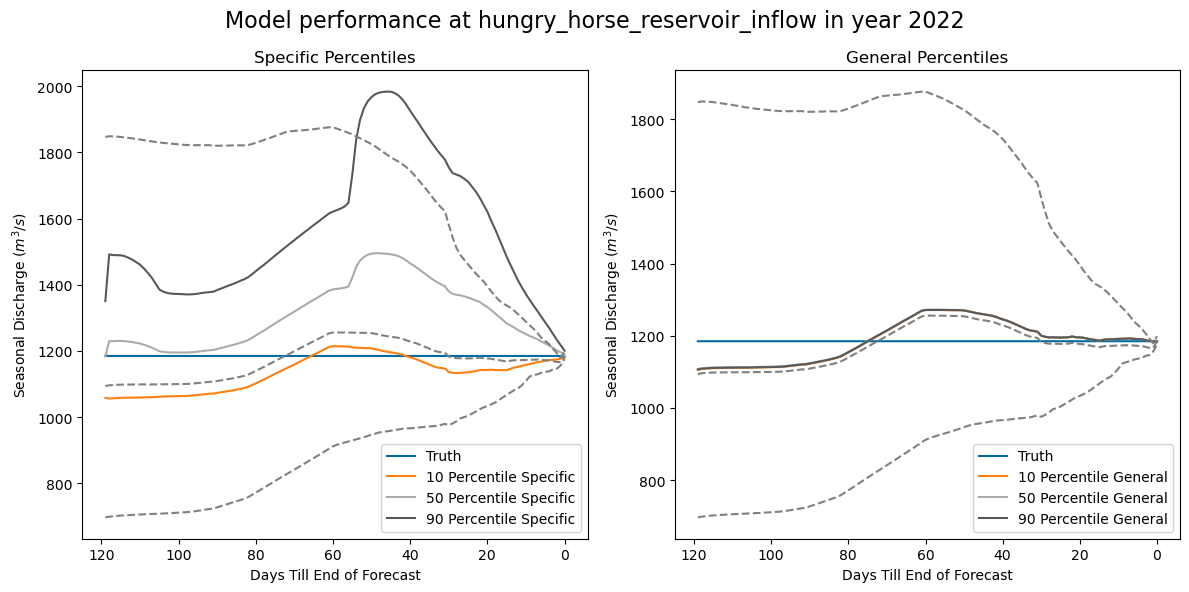

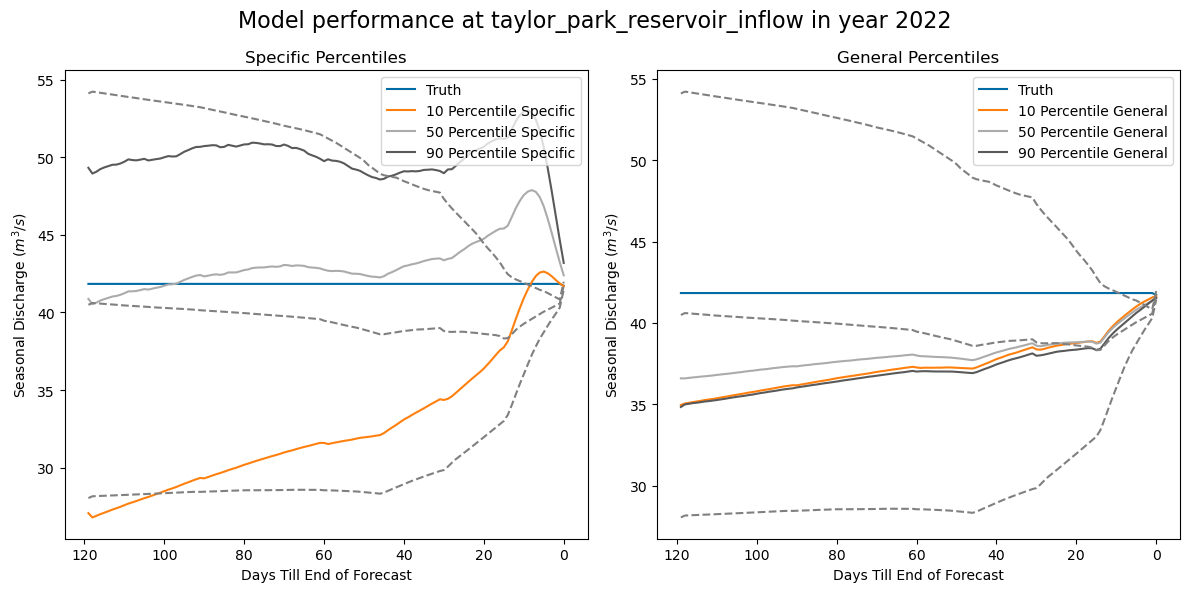

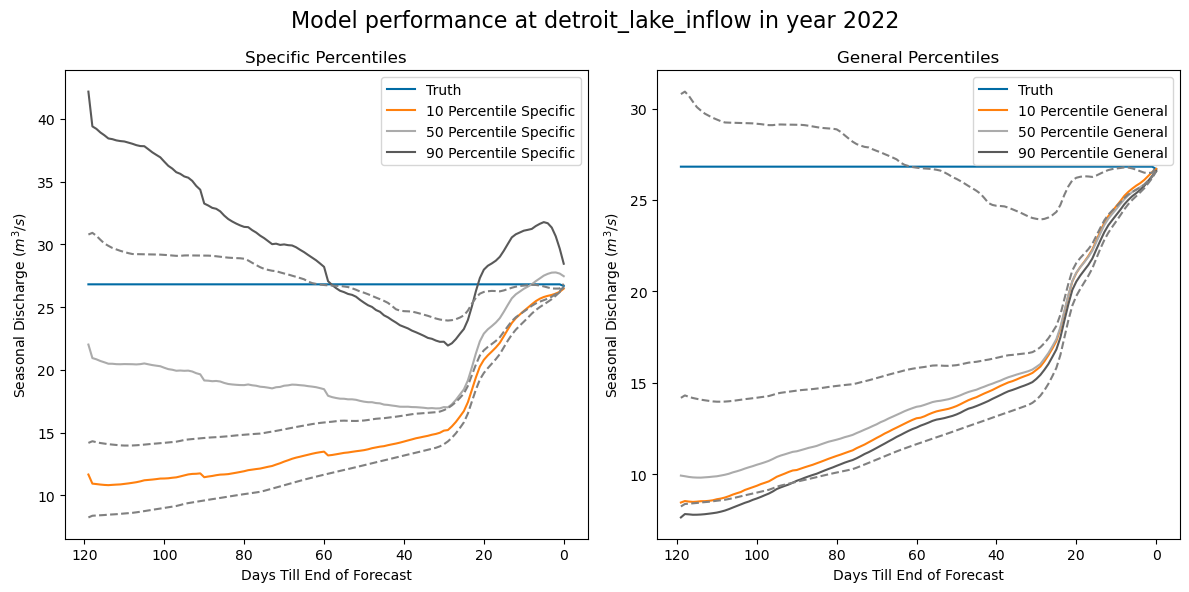

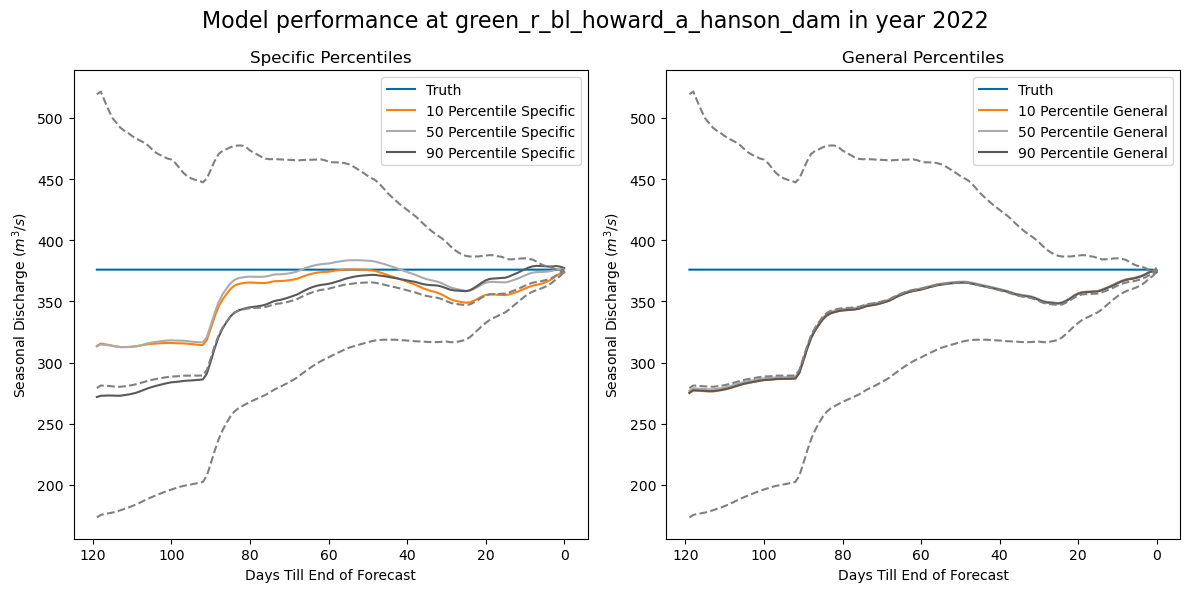

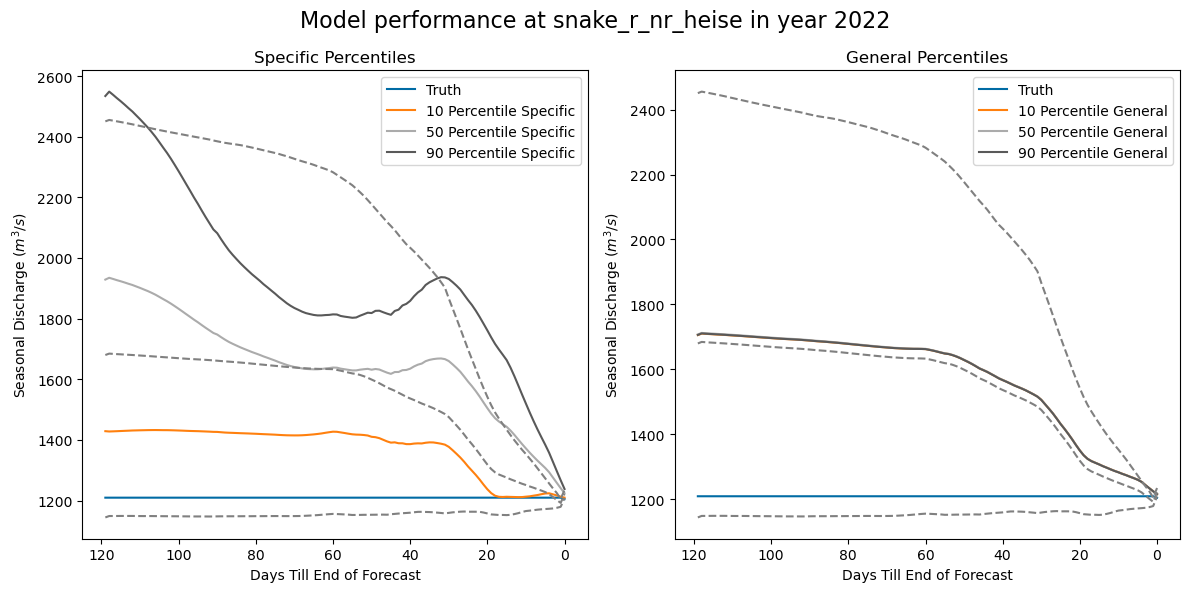

In [ ]:
start_season_date = '2022-02-01'
end_season_date = '2022-05-31'
years = [2000,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020, 2022]
daily_flow['dillon_reservoir_inflow']
for basin in basins:
#for year in years:
    start_season_date = f'{year}-02-01'
    end_season_date = f'{year}-05-31'

    #basin = 'dillon_reservoir_inflow'

    flow_scaler_filename = f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
    flow_scaler = joblib.load(flow_scaler_filename) 

    Specific, General, Truth, Climatology_10, Climatology_50, Climatology_90  = test_performance_for_basin_and_season(basin, Hydra_Body, General_Hydra_Head, model_heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, Static_variables, device, end_season_date, start_season_date, flow_scaler, furthest_distance=120, feed_forcing= feed_forcing)


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for Specific
    No_Days = len(Specific[:, 0])
    Days_Til_Season = No_Days - np.arange(1, No_Days + 1)

    axes[0].plot(Truth, label='Truth')
    axes[0].plot(Days_Til_Season, Specific[:, 0], label='10 Percentile Specific')
    axes[0].plot(Days_Til_Season, Specific[:, 1], label='50 Percentile Specific')
    axes[0].plot(Days_Til_Season, Specific[:, 2], label='90 Percentile Specific')
    # axes[0].plot(Days_Til_Season, Climatology_10, label='10 Percentile Climatology')
    # axes[0].plot(Days_Til_Season, Climatology_50, label='50 Percentile Climatology')
    # axes[0].plot(Days_Til_Season, Climatology_90, label='90 Percentile Climatology')

    axes[0].legend()
    axes[0].set_title('Specific Percentiles')

    # Plot for General
    axes[1].plot(Truth, label='Truth')
    axes[1].plot(Days_Til_Season, General[:, 0], label='10 Percentile General')
    axes[1].plot(Days_Til_Season, General[:, 1], label='50 Percentile General')
    axes[1].plot(Days_Til_Season, General[:, 2], label='90 Percentile General')


    axes[1].legend()
    axes[1].set_title('General Percentiles')

    for ax in axes:
        ax.set_ylabel('Seasonal Discharge ($m^3/s$)')
        ax.invert_xaxis()
        ax.set_xlabel('Days Till End of Forecast')



    plt.suptitle(f'Model performance at {basin} in year {year}', fontsize=16)

    Clmiatology = True
    # Need to make code to get climatology of the season of interest
    if Clmiatology == True:
        # Add horizontal dashed lines for quantiles
        axes[0].plot(Days_Til_Season, Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
        axes[0].plot(Days_Til_Season, Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
        axes[0].plot(Days_Til_Season, Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')

        axes[1].plot(Days_Til_Season,Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
        axes[1].plot(Days_Til_Season,Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
        axes[1].plot(Days_Til_Season,Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')
        
    plt.tight_layout()
    plt.show()

In [ ]:
# Signed off on: Hungry Horse, Colville, Pueblo, ruedi, dillon, boise, missouri, libby, pecos, virgin, yampa, merced, animas, detroit
# not great but improved: snake, taylor, owyhee, fontenelle
model_dir = '/data/gbmc/Rodeo_Submission/Models/10_01_Models/'
daily_flow['dillon_reservoir_inflow']
basin = 'dillon_reservoir_inflow'

# Construct the full path for saving the model
save_path = os.path.join(model_dir, f'{basin}_Head.pth')
# Save the model 
torch.save(model_heads[f'{basin}'], save_path)


# save_path = os.path.join(model_dir, f'General_Head.pth')
# # Save the model
# torch.save(General_Hydra_Head, save_path)

# save_path = os.path.join(model_dir, f'General_Body.pth')
# # Save the model
# torch.save(Hydra_Body, save_path)

In [ ]:
# Create an array of indices as the x-values
indices = np.arange(len(general_losses))
skip = 0
# Fit linear regression models
general_coef = np.polyfit(indices[skip:], val_general_losses[skip:], 1)
gen_line_of_best_fit = np.polyval(general_coef[skip:], indices[skip:])
specific_coef = np.polyfit(indices[skip:], val_specific_losses[skip:], 1)
spec_line_of_best_fit = np.polyval(specific_coef[skip:], indices[skip:])

# Plot the loss values
plt.plot(val_general_losses[skip:], label='General Losses', color='blue')
plt.plot(val_specific_losses[skip:], label='Specific Losses', color='green')
plt.plot(climate_losses[skip:], label='Climate Losses', linestyle = '--', color='grey')
# Plot the lines of best fit
plt.plot(gen_line_of_best_fit, label='General Line of Best Fit', linestyle='--', color='red')
plt.plot(spec_line_of_best_fit, label='Specific Line of Best Fit', linestyle='--', color='orange')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
# 500 vs 1500 currently

In [ ]:
# Create an array of indices as the x-values
indices = np.arange(len(general_losses))
plt.plot( ( ( np.array(climate_losses[skip:]) - np.array(val_general_losses[skip:]) )/np.array(climate_losses[skip:]) ), label='General Losses', color='blue')
plt.plot( ( ( np.array(climate_losses[skip:]) - np.array(val_specific_losses[skip:]) )/np.array(climate_losses[skip:]) ), label='Specific Losses', color='green')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
# 500 vs 1500 currently

# Checking distribution of basins and days used in model

In [ ]:
def Basin_Count(All_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, static_indices, optimizer, scheduler, criterion, early_stopper = None, n_epochs = 20, batch_size = 2, group_lengths = [89, 90, 91, 92] , Train_Mode=True, device = 'cpu', feed_forcing = True):
    basin_usage_counter = defaultdict(int)

    Size = len(All_Dates)

    # Set models to train mode if Train_Mode is True, else set to evaluation mode
    Hydra_Body.train(Train_Mode)
    General_Hydra_Head.train(Train_Mode)
    [model_heads[f'{basin}'].train(Train_Mode) for basin in basins]

    for epoch in range(n_epochs):  
        permutation = torch.randperm(len(All_Dates))

        for i in range(0, Size, batch_size):
            indices = permutation[i:i + batch_size]
            batch_dates = All_Dates[indices.cpu().numpy().astype(int)]
            basin = np.random.choice(basins)

            min_day = min(180 - forecast_datetime.dayofyear for forecast_datetime in batch_dates) + 1
            final_forcing_distance = np.random.choice(range(round(0.49*min_day), min_day + 1) )
            final_forcing_distance = min_day

            basin_key = f"{basin}_{final_forcing_distance}"
            basin_usage_counter[basin_key] += 1
        
        return basin_usage_counter
    


In [ ]:
# Extract basins and distances from keys
n_epochs = 3000
basin_usage_counter = Basin_Count(All_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, n_epochs=n_epochs, batch_size= 1, group_lengths=group_lengths, Train_Mode=True, device=device, feed_forcing = False)

basin_info = [key.rsplit('_', 1) for key in basin_usage_counter.keys()]

# Convert to numeric values if needed
basins, distances = zip(*[(info[0], int(info[1])) for info in basin_info])

# Get unique basins and distances
unique_basins = list(set(basins))
unique_distances = list(set(distances))

# Create a matrix of counts
counts_matrix = [
    [basin_usage_counter[f"{basin}_{distance}"] for distance in unique_distances] for basin in unique_basins
]

# Create a heatmap using Matplotlib
plt.imshow(counts_matrix, cmap="YlGnBu", interpolation="nearest", aspect="auto")
plt.colorbar(label="Counts")
plt.yticks(range(len(unique_basins)), unique_basins)
plt.xlabel('Final Forcing Distance')
plt.ylabel('Basin')
plt.title('Basin and Final Forcing Distance Usage Heatmap')
plt.show()

# Evaluating Performance

In [ ]:
# green pueblo colvilli
# green need works, so does pueblo in their issues when getting close

year = 2012
start_season_date = f'{year}-01-31' 
end_season_date = f'{year}-05-31'
flow['pueblo_reservoir_inflow']
basin = 'pueblo_reservoir_inflow'

flow_scaler_filename = f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
flow_scaler = joblib.load(flow_scaler_filename) 

Specific, General, Truth, Climatology_10, Climatology_50, Climatology_90  = test_performance_for_basin_and_season(basin, Hydra_Body, General_Hydra_Head, model_heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, Static_variables, device, end_season_date, start_season_date, flow_scaler, furthest_distance=120, feed_forcing= feed_forcing)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Specific
No_Days = len(Specific[:, 0])
Days_Til_Season = No_Days - np.arange(1, No_Days + 1)

axes[0].plot(Truth, label='Truth')
axes[0].plot(Days_Til_Season, Specific[:, 0], label='10 Percentile Specific')
axes[0].plot(Days_Til_Season, Specific[:, 1], label='50 Percentile Specific')
axes[0].plot(Days_Til_Season, Specific[:, 2], label='90 Percentile Specific')
# axes[0].plot(Days_Til_Season, Climatology_10, label='10 Percentile Climatology')
# axes[0].plot(Days_Til_Season, Climatology_50, label='50 Percentile Climatology')
# axes[0].plot(Days_Til_Season, Climatology_90, label='90 Percentile Climatology')

axes[0].legend()
axes[0].set_title('Specific Percentiles')

# Plot for General
axes[1].plot(Truth, label='Truth')
axes[1].plot(Days_Til_Season, General[:, 0], label='10 Percentile General')
axes[1].plot(Days_Til_Season, General[:, 1], label='50 Percentile General')
axes[1].plot(Days_Til_Season, General[:, 2], label='90 Percentile General')


axes[1].legend()
axes[1].set_title('General Percentiles')

for ax in axes:
    ax.set_ylabel('Seasonal Discharge ($m^3/s$)')
    ax.invert_xaxis()
    ax.set_xlabel('Days Till End of Forecast')



plt.suptitle(f'Model performance at {basin}', fontsize=16)

Clmiatology = True
# Need to make code to get climatology of the season of interest
if Clmiatology == True:
    # Add horizontal dashed lines for quantiles
    axes[0].plot(Days_Til_Season, Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
    axes[0].plot(Days_Til_Season, Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
    axes[0].plot(Days_Til_Season, Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')

    axes[1].plot(Days_Til_Season,Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
    axes[1].plot(Days_Til_Season,Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
    axes[1].plot(Days_Til_Season,Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')
    
plt.tight_layout()
plt.show()


In [ ]:
# Save all models to a model path

# model_dir = '/data/gbmc/Rodeo_Submission/Models/10_01_Models/'

# for basin in basins:
#     # Construct the full path for saving the model
#     save_path = os.path.join(model_dir, f'{basin}_Head.pth')
#     # Save the model 
#     torch.save(model_heads[f'{basin}'], save_path)


# save_path = os.path.join(model_dir, f'General_Head.pth')
# # Save the model
# torch.save(General_Hydra_Head, save_path)

# save_path = os.path.join(model_dir, f'General_Body.pth')
# # Save the model
# torch.save(Hydra_Body, save_path)

# Tuning Loop

In [ ]:
# Takes 10 minutes per group
n_epochs = 2
batch_size = 2
group_lengths = [5, 30, 60, 89, 90, 91, 92, 120, 150, 180]

# Initialize DataFrames to store average losses
average_losses_df_specific = pd.DataFrame(columns=["LearningRate", "BodyOut", "BodySize", "HeadSize", "AverageLoss"])
average_losses_df_general = pd.DataFrame(columns=["LearningRate", "BodyOut", "BodySize", "HeadSize",  "AverageLoss"])

static_size = 1
learning_rates = [1e-5]
body_outs = [5, 15]
body_sizes = [32, 64, 256]

head_size, head_output_size, head_hidden_size, head_num_layers, head_dropout, head_bidirectional = 256, 3, 256, 1, 0.1, False
body_input_size, body_num_layers, body_dropout, body_bidirectional = 9 + 3 + static_size, 1, 0.1, False

days  = 90
hidden_variables_size = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Size = len(All_Dates)

for learning_rate in learning_rates:
    for body_out in body_outs:
        for body_size in body_sizes:
                LR = learning_rate
                body_output_size = body_out
                body_hidden_size = body_size
                learning_rate_body = LR

                head_input_size = body_input_size + body_output_size
                # head_input_size = body_input_size
                learning_rate_head = learning_rate
                learning_rate_general_head = learning_rate

                # Randomness
                seed = 42 ; torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

                Hydra_Body, model_heads, General_Hydra_Head, optimizer, scheduler = initialize_models_optimizers(basins, body_input_size, body_hidden_size, body_num_layers, body_output_size, body_dropout, body_bidirectional,
                                 head_input_size, head_hidden_size, head_num_layers, head_output_size, head_dropout, head_bidirectional,
                                 days, hidden_variables_size, learning_rate_body, learning_rate_head, learning_rate_general_head, LR, device)
                


                # Train Model. should add a Stopper to the code here, and then tune that stopper when I get a feel for the smoothness of the model
                Model_Run(All_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, n_epochs=n_epochs, batch_size=batch_size, group_lengths=group_lengths, Train_Mode=True, device=device)
                # Test Model
                general_loss, specific_loss = Model_Run(Val_Dates, basins, Hydra_Body, General_Hydra_Head, model_heads, era5, daily_flow, climatological_flows, climate_indices, seasonal_forecasts, Static_variables, optimizer, scheduler, criterion, n_epochs= n_epochs, batch_size=batch_size, group_lengths=group_lengths, Train_Mode=False, device=device)

                # Calculate average losses for the last 5 epochs
                avg_specific_loss = np.sum(specific_loss[-5:]) / 5
                avg_general_loss = np.sum(general_loss[-5:]) / 5
                print(avg_specific_loss)

                

                average_losses_df_specific.loc[len(average_losses_df_specific)] = {
                    "LearningRate": learning_rate,
                    "BodyOut": body_out,
                    "BodySize": body_size,
                    "HeadSize": head_size,
                    "AverageLoss": avg_specific_loss
                }
                average_losses_df_general.loc[len(average_losses_df_general)] = {
                    "LearningRate": learning_rate,
                    "BodyOut": body_out,
                    "BodySize": body_size,
                    "HeadSize": head_size,
                    "AverageLoss": avg_general_loss
                }
                
                print(average_losses_df_general)
                print(average_losses_df_specific)


general_csv_path = '/data/gbmc/Rodeo_Submission/Tuning_General_Loss.csv'
specific_csv_path = '/data/gbmc/Rodeo_Submission/Tuning_Specific_Loss.csv'
average_losses_df_general.to_csv(general_csv_path, index=False)
average_losses_df_specific.to_csv(specific_csv_path, index=False)


In [ ]:
specific_loss

In [ ]:
general_csv_path = '/data/gbmc/Rodeo_Submission/Tuning_General_Loss.csv'
specific_csv_path = '/data/gbmc/Rodeo_Submission/Tuning_Specific_Loss.csv'
average_losses_df_general.to_csv(general_csv_path, index=False)
average_losses_df_specific.to_csv(specific_csv_path, index=False)

In [ ]:
# Create an array of indices as the x-values
indices = np.arange(len(general_losses))

# Plot the loss values
plt.plot(general_losses, label='General Losses', color='blue')
plt.plot(specific_losses, label='Specific Losses', color='blue')
plt.plot(val_general_losses, label='General Validation Losses', color='red')
plt.plot(val_specific_losses, label='Specific Validation Losses', color='red')


# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()